# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [4]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [8]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:02<00:00, 2490.92it/s]


In [25]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [140]:
## Similartly you can do preprocessing for review summary also.

#here i will be preprocessing the summary data
#let us print some random summary rows here
sum1=final['Summary'].values[0]
print(sum1)
print("*"*60)

sum2=final['Summary'].values[100]
print(sum2)
print("*"*60)

sum3=final['Summary'].values[550]
print(sum3)
print("*"*60)

sum4=final['Summary'].values[1550]
print(sum4)
print("*"*60)

sum5=final['Summary'].values[4170]
print(sum5)
print("*"*60)
#below I have successfully printed some of the summary text

Great Product
************************************************************
Shipping is INSANE!!!
************************************************************
CAUTION!!!  ADDICTIVE CANDY&lt; VERY >
************************************************************
Great little treats
************************************************************
Hot cocoa k-cups
************************************************************


In [141]:
final.Summary.head(10)
#ok! so it looks like the summary has a lot of punctuation marks.

1146                                        Great Product
1145                       WOW Make your own 'slickers' !
3481                                    Classic Condiment
1112      The best twice baked potatoes you'll ever have!
1176                                             5 Woofs!
1173    Healthy, non-fattening, just the right size an...
1193                                     Rich J Wyzykoski
10                        The Best Hot Sauce in the World
2489                                               Tender
3479                                Put it over all meats
Name: Summary, dtype: object

In [142]:
#so let's remove those punctuation marks first
#https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string-in-python
#sum1=re.sub(r"?","",sum1)

import string
#sum1.translate(None,string.punctuation)
#https://stackoverflow.com/questions/23175809/str-translate-gives-typeerror-translate-takes-one-argument-2-given-worked-i
sum5 = sum5.translate(str.maketrans('','',string.punctuation))
print(sum5)

Hot cocoa kcups


In [143]:
#there is no need to parse the summary section using beautifulsoup because there are no html tags in summary section
sum2= sum2.translate(str.maketrans('','',string.punctuation))
print(sum2)
#so the above punctuation remover seems to be working fine

Shipping is INSANE


In [144]:
#let's check again if there are any summary where they have used short words
sum_rev=final['Summary'].values[1079:1179]
print(sum_rev)
#unfortunately we cannot search randomly and find the summary that has a short word, so let's take a subset randomly and we can see 
#that most of the summary does not have short words and filter for them are already covered in the review section

['YUM!!!' 'Beautiful fresh and it came easrly!v Yey!!' 'Tasty Fruit'
 'Chopped Clams' 'Excellent starter set.'
 "Just a tad too small for my wife's taste, but kids and I love it"
 'Great!' 'Entire family loves them' 'DELICIOUS' 'wonderful' 'Tasty.'
 'If You REALLY Like Sweet...' 'Needs a bigger splash'
 'EXCELLENT,TASTY, CHEWY,' 'Bland' 'Lots of flavor, but not too sweet'
 'Tasty, good value'
 "Pineapple flavored coconut water from Indonesia... there's something we really need!"
 'Tastes ok but has bits of shells'
 'In my opinion, the best clam chowder out there!  A perfect winter meal.'
 "Franch's is the best" 'Microwave Popcorn' 'beer nuts' 'Great Chips'
 'The Cat likes it, too!' 'Big Disappointment'
 'so good even a dog does not turn its nose up at it.'
 'What is the carbon footprint of this product?' 'Great Product'
 "My aunt's favorite" 'Smooth Brown Wonderfulness!'
 'Our baby loves this milk.' 'Cheaper from Penta.com' 'Spicy but good'
 'Arrived Fresh and in Good Shape.' 'Great St

In [145]:
# https://stackoverflow.com/a/47091490/4084039
#with minor modification we can just utilize the same function that was used for the review phrase

import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"Don't", "do not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\'em", " them", phrase)
    return phrase

In [146]:
#check a random summary
new_sum=decontracted(final['Summary'].values[1206])
print(new_sum)

Tasteless but low calorie


In [147]:
#using the code mentioned above for processing the summary column of the given dataframe 

from tqdm import tqdm
preprocessed_summaries = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_summaries.append(sentence.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1584.32it/s]


In [148]:
#now let's print out some of the random values just to check if the above code has worked fine or not
preprocessed_summaries[500:4000:100]
#preprocessed_summaries[500:900:10]
#preprocessed_summaries[480:900:5]
#checked with several random phrases the preprocessing of the summary column looks fine

['great taste convenient',
 'best canned fruit ever eatten',
 'great way order',
 'yuck',
 'love',
 'delicious',
 'microwave popcorn',
 'popchips hmmmm hmmm hmmm',
 'great keep hand desserts',
 'best cereal ever eaten',
 'smooth coffee highly recommended',
 'add sugar',
 'popchips satisfy salt crunch craving',
 'shocked amazing',
 'ten year old doxie',
 'hazelnut coffee smells tastes like buttered popcorn not much like hazelnut',
 'tangy goodness',
 'altoids mini mints tins',
 'best kept secret not really',
 'better taste expected',
 'great food',
 'good coffee',
 'awesome cereal',
 'close original hard candy',
 'marianne',
 'yay',
 'great hot chocolate',
 'best',
 'good price great stocking',
 'thyme leaf',
 'chocolate heaven',
 'smiles',
 'best',
 'disgusting',
 'omg cookies']

# [4] Featurization

## [4.1] BAG OF WORDS

In [27]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [28]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [29]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [30]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [31]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('looking', 0.995932936668396), ('overall', 0.9952586889266968), ('anything', 0.9950978755950928), ('excellent', 0.9949459433555603), ('care', 0.9947897791862488), ('unless', 0.9947153329849243), ('value', 0.9946343898773193), ('worth', 0.9946264028549194), ('likes', 0.9945932030677795), ('think', 0.9944961667060852)]
[('wife', 0.9994990825653076), ('become', 0.99944007396698), ('common', 0.999397873878479), ('de', 0.9993942379951477), ('varieties', 0.9993917942047119), ('turned', 0.9993715882301331), ('experience', 0.9993676543235779), ('nearly', 0.999348521232605), ('pods', 0.9993376135826111), ('unfortunately', 0.9993327856063843)]


In [32]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [33]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:06<00:00, 809.08it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [34]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [35]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:31<00:00, 159.09it/s]


In [36]:
final['Cleaned_text'] = preprocessed_reviews

# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [37]:
# Please write all the code with proper documentation
final = final.sort_values('Time',axis= 0,inplace = False , na_position = 'last',ascending = True)
X = final['Cleaned_text'].values
X = X[:50000]

In [38]:
count_vect = CountVectorizer()
bow = count_vect.fit_transform(X)

In [39]:
list_of_sent = []
for i in X:
    sent = []
    for word in i.split():
        sent.append(word)
    list_of_sent.append(sent)

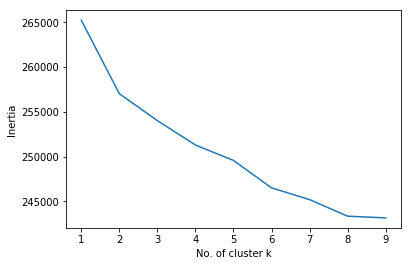

In [40]:
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
from sklearn.cluster import KMeans
dic = {}
for i in range(1,10):
    clus = KMeans(n_clusters = i)
    clus.fit(bow)
    dic[i] = clus.inertia_
plt.plot(list(dic.keys()), list(dic.values()))
plt.xlabel("No. of cluster k")
plt.ylabel("Inertia")
plt.show()

In [41]:
optimal_k = KMeans(n_clusters = 8)
p = optimal_k.fit_predict(bow)

In [42]:
#https://andrew47.github.io/scikitlearn-cluster.html
centroids = pd.DataFrame(optimal_k.cluster_centers_)
centroids.columns = count_vect.get_feature_names()
centroids

,aa,aahhhs,aback,abandon,abates,abbott,abby,abdominal,abiding,ability,...,zipper,zippy,zito,zola,zomg,zon,zoo,zucchini,zupas,zuppa
0,0.000000,0.000309,0.000000,0.000000,0.000000,0.000000,0.000309,0.000000,0.000309,0.001234,...,0.000309,0.000617,0.000000,0.000000,0.000309,0.000309,0.000000,0.000309,0.000309,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028037,0.000000,0.000000
2,0.008696,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000848,0.000848,0.000000,0.000000,0.000000,0.000000,0.000000,0.005089,...,0.000000,0.000848,0.000848,0.000000,0.000000,0.000000,0.002545,0.000848,0.000000,0.000848
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.004975,0.000000,0.004975,0.000000,0.000000,...,0.004975,0.000000,0.000000,0.004975,0.000000,0.000000,0.000000,0.004975,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.008475,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

In [43]:
#https://andrew47.github.io/scikitlearn-cluster.html
for i in range(0, len(centroids)):
    print(centroids.ix[i,:].sort_values(ascending = False)[0:10])
    print("\n")

not        0.315026
great      0.296205
good       0.250231
product    0.215366
love       0.198396
like       0.183585
taste      0.154890
flavor     0.153965
one        0.147485
best       0.131441
Name: 0, dtype: float64


food       4.205607
dog        2.327103
not        2.102804
organic    0.878505
one        0.794393
newman     0.728972
would      0.728972
dogs       0.607477
like       0.607477
no         0.560748
Name: 1, dtype: float64


coffee    4.913043
not       1.704348
cup       0.782609
taste     0.773913
like      0.765217
good      0.669565
decaf     0.573913
flavor    0.565217
one       0.426087
drink     0.400000
Name: 2, dtype: float64


not        1.936387
like       0.701442
good       0.445293
taste      0.413062
one        0.370653
would      0.350297
flavor     0.336726
chips      0.332485
great      0.314673
product    0.279050
Name: 3, dtype: float64


chips     8.363636
not       3.500000
kettle    3.000000
potato    2.454545
bag       1.909091
brand     1

In [44]:
# Please write all the code with proper documentation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

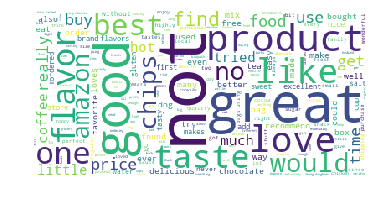

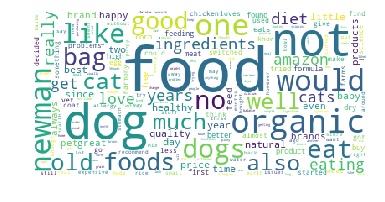

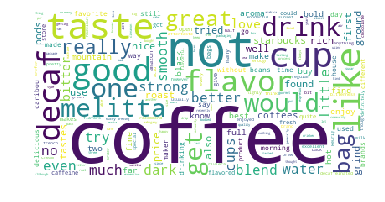

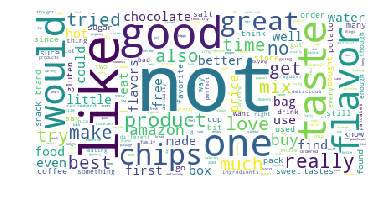

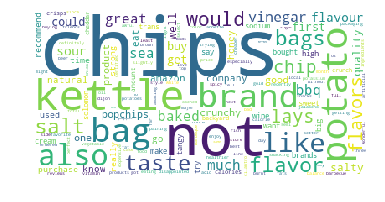

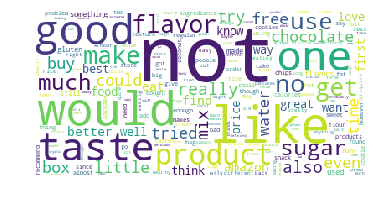

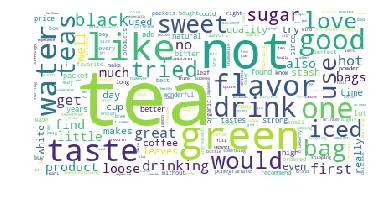

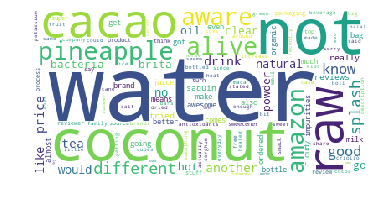

In [45]:
#https://andrew47.github.io/scikitlearn-cluster.html
for i in range(0, len(centroids)):
    wordcloud = WordCloud(background_color = 'white')
    
    kMeansWordCloud = wordcloud.generate_from_frequencies(centroids.ix[i,:])
    plt.figure()
    plt.imshow(kMeansWordCloud)
    plt.axis("off")

<b>Observations:</b><br>
1.From cluster 1 we can see that there are mixed reactions for the products they bought.<br>
2.cluster 2 says words like 'dog','food' among others in bigger sized fonts that means they occur in higher numbers<br>
3.Likewise, the clusters above seems to pretty much depict correctly the clusters.

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [46]:
# Please write all the code with proper documentation
tfidf_vect = TfidfVectorizer()
tfidf_fit = tfidf_vect.fit(X)
tfidf_train = tfidf_vect.fit_transform (X)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean = False)
X_tr = sc.fit_transform(tfidf_train)

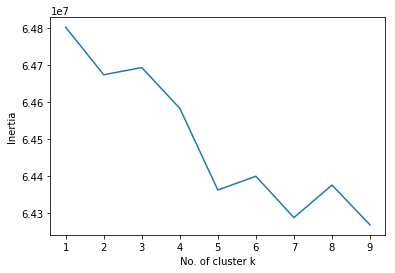

In [47]:
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
from sklearn.cluster import KMeans
dit = {}
for i in range(1,10):
    clus_tf = KMeans(n_clusters = i)
    clus_tf.fit(X_tr)
    dit[i] = clus_tf.inertia_
plt.plot(list(dit.keys()), list(dit.values()))
plt.xlabel("No. of cluster k")
plt.ylabel("Inertia")
plt.show()

In [48]:
opt_k = KMeans(n_clusters = 7)
p = opt_k.fit_predict(tfidf_train)

In [49]:
#https://andrew47.github.io/scikitlearn-cluster.html
centroids = pd.DataFrame(opt_k.cluster_centers_)
centroids.columns = tfidf_fit.get_feature_names()
centroids

,aa,aahhhs,aback,abandon,abates,abbott,abby,abdominal,abiding,ability,...,zipper,zippy,zito,zola,zomg,zon,zoo,zucchini,zupas,zuppa
0,0.000351,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.001076,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000677,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000628,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001245,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000078,0.000056,0.000149,0.000000,0.000019,0.000123,0.000031,0.000064,0.000627,...,0.000014,0.000249,0.00006,0.000034,0.000079,0.000091,0.000151,0.000172,0.000061,0.000078
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

In [50]:
#https://andrew47.github.io/scikitlearn-cluster.html
for i in range(0, len(centroids)):
    print(centroids.ix[i,:].sort_values(ascending = False)[0:10])
    print("\n")

coffee    0.270149
not       0.051146
cup       0.041902
decaf     0.039405
like      0.037293
taste     0.036403
smooth    0.031348
bitter    0.031323
good      0.031158
strong    0.030956
Name: 0, dtype: float64


food       0.176340
dog        0.140885
dogs       0.051517
newman     0.040252
not        0.038689
loves      0.031744
cat        0.029574
organic    0.028442
one        0.026180
eat        0.025783
Name: 1, dtype: float64


chips      0.221558
salt       0.058574
not        0.051348
potato     0.051106
bag        0.045734
flavor     0.041734
kettle     0.041242
great      0.041038
vinegar    0.039085
flavors    0.035836
Name: 2, dtype: float64


tea      0.306849
green    0.055266
not      0.039021
like     0.034649
iced     0.032502
teas     0.031911
drink    0.031286
love     0.029457
water    0.026242
taste    0.025923
Name: 3, dtype: float64


mix         0.113885
gluten      0.109046
pancakes    0.095389
free        0.084039
bisquick    0.063206
waffles     0.051079


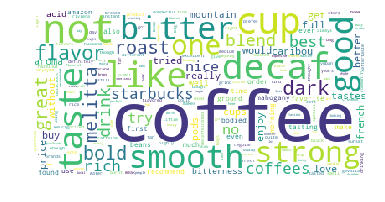

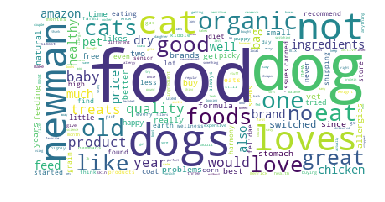

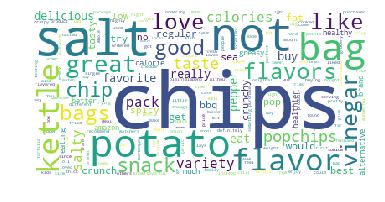

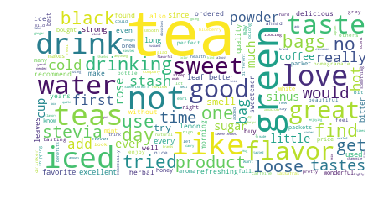

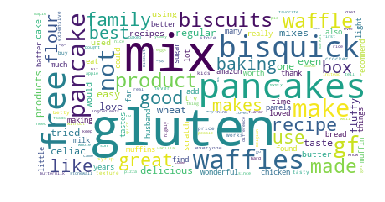

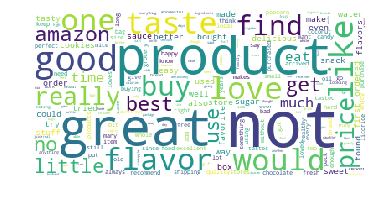

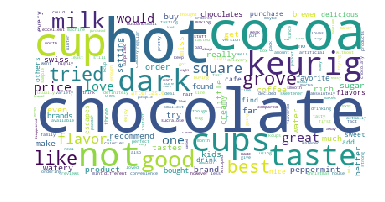

In [51]:
# Please write all the code with proper documentation
#https://andrew47.github.io/scikitlearn-cluster.html
from wordcloud import WordCloud
from matplotlib.pyplot import figure
for i in range(0, len(centroids)):
    wordcloud = WordCloud(background_color = 'white')
    
    kMeansWordCloud = wordcloud.generate_from_frequencies(centroids.ix[i,:])#generates wordcloud for ith row and all corresponding columns
    plt.figure()
    plt.imshow(kMeansWordCloud)
    plt.axis("off")

<b>Observation:</b><br>
1.cluster 1 speaks more about coffee being strong, smooth, taste etc.<br>
2.Second cluster seems to emphasize on dog food related items.<br>
3.Likewise,all the remaining clusters are being grouped properly.

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [71]:
data = sent_vectors

In [72]:
#https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob/master/Apply%20clustering%20%20on%20Amazon%20Food%20Reviews.ipynb
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k).fit(data)
    
    Sum_of_squared_distances.append(kmeans.inertia_)

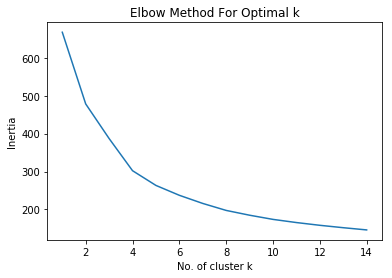

In [75]:
#https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f
plt.plot(K, Sum_of_squared_distances)
plt.xlabel('No. of cluster k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

<b>Observation:</b><br>
1.From the above graph we know that the elbow appears to be present at k=4.

In [77]:
#I have grouped label corresponding to each cluster into their corresponding cluster
#https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob/master/Apply%20clustering%20%20on%20Amazon%20Food%20Reviews.ipynb
reviews = final['Cleaned_text'].values
optimal_k = 4
# Variable that will be used in the conclusion 
avg_w2v_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(data)

# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    else :
        cluster4.append(reviews[i]) 

In [78]:
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))

No. of reviews in Cluster-1 :  2070

No. of reviews in Cluster-2 :  1518

No. of reviews in Cluster-3 :  15

No. of reviews in Cluster-4 :  1383


### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

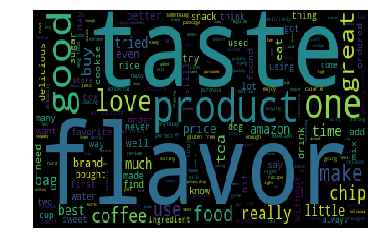

In [81]:
# Please write all the code with proper documentation
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 1
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(cluster1)):
    t_b = t_b + cluster1[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

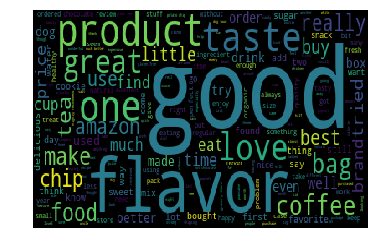

In [82]:
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 2
t_b = ''
for j in range(len(cluster2)):
    t_b = t_b + cluster2[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

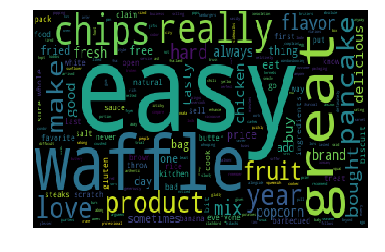

In [83]:
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 3
t_b = ''
for j in range(len(cluster3)):
    t_b = t_b + cluster3[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

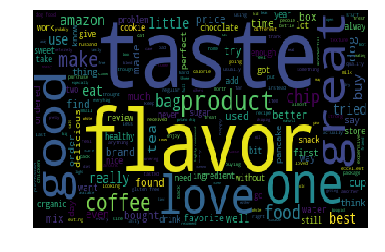

In [84]:
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 4
t_b = ''
for j in range(len(cluster4)):
    t_b = t_b + cluster4[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

<b>Observation:</b><br>
1.From the first cluster we can see that words like 'taste','flavor' etc are seen in large fonts.<br>
2.Second cluster seems to be better at good reviews which can be assumed from the words like 'good','love','great taste' etc.<br>
3.Likewise, the other two clusters seems pretty good.

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [85]:
data = tfidf_sent_vectors

In [86]:
#https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k).fit(data)
    
    Sum_of_squared_distances.append(kmeans.inertia_)

<b>Elbow method to determine best k:</b>

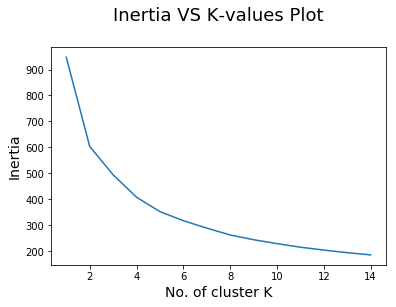

In [87]:
# Draw Loss VS K values plot
#https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f
plt.plot(K, Sum_of_squared_distances)
plt.xlabel('No. of cluster K',size=14)
plt.ylabel('Inertia',size=14)
plt.title('Inertia VS K-values Plot\n',size=18)
plt.show()

<b>Observation:</b><br>
1.We can see from the plot that the elbow seems to occur at k=2. So let's take it as the optimal K.

In [88]:
#https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob/master/Apply%20clustering%20%20on%20Amazon%20Food%20Reviews.ipynb
optimal_k = 2
# Variable that will be used in the conclusion 
tfidf_w2v_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(data)

# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i]) 

In [89]:
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  2084

No. of reviews in Cluster-2 :  2902


### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

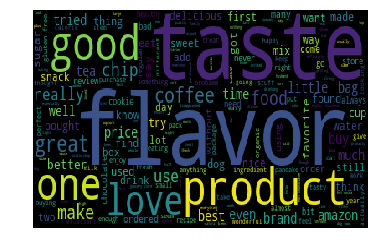

In [90]:
# Please write all the code with proper documentation
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 1
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(cluster1)):
    t_b = t_b + cluster1[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

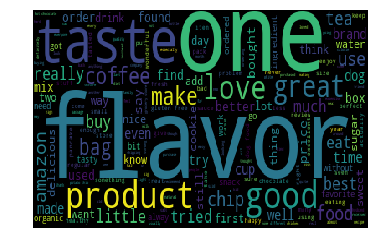

In [91]:
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 2
t_b = ''
for j in range(len(cluster2)):
    t_b = t_b + cluster2[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

<b>Observation:</b><br>
1.From the above cloud we can see that the words like 'product','taste','good','flavor' etc. can be seen in a bigger size.<br>
2.Words like 'taste''good'repeat similar to the ones we saw in avg w2v.<br>
3.This would mean that the customers gave more positive reviews about the food they purchased.

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [94]:
#https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob/master/Apply%20Hierarchical%20clustering%20on%20Amazon%20Food%20Reviews.ipynb
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# We will collect different 40K rows without repetition from time_sorted_data dataframe
my_final = time_sorted_data.take(np.random.permutation(len(final))[:5000])

x = my_final['Cleaned_text'].values

In [95]:
# Please write all the code with proper documentation
data = sent_vectors

<h4>Agglomerative clustering with 2 clusters</h4>

In [98]:
#https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob/master/Apply%20Hierarchical%20clustering%20on%20Amazon%20Food%20Reviews.ipynb
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=2).fit(data)

reviews = X
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  3811

No. of reviews in Cluster-2 :  1175


<h4>Agglomerative clustering with 5 clusters</h4>

In [101]:
#https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob/master/Apply%20Hierarchical%20clustering%20on%20Amazon%20Food%20Reviews.ipynb
model = AgglomerativeClustering(n_clusters=5).fit(data)

# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif model.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif model.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif model.labels_[i] == 3:
        cluster4.append(reviews[i])
    else :
        cluster5.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))

No. of reviews in Cluster-1 :  948

No. of reviews in Cluster-2 :  1160

No. of reviews in Cluster-3 :  2043

No. of reviews in Cluster-4 :  15

No. of reviews in Cluster-5 :  820


### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

<h4>The below 2 wordclouds are with the agglomerative clustering with 2 clusters</h4>

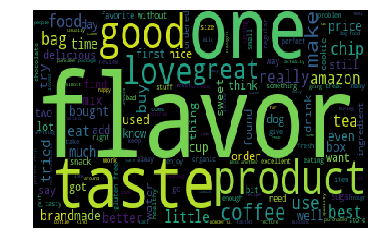

In [99]:
# Please write all the code with proper documentation
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 1
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(cluster1)):
    t_b = t_b + cluster1[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

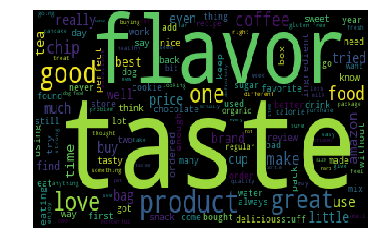

In [100]:
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 2
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(cluster2)):
    t_b = t_b + cluster2[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

<b>Observation:</b><br>
1.From the two wordclouds above we can see that the words 'flavor','taste' etc. are the prominent ones in both.<br>
2.From the wordclouds we can see that most of the words are positive about the product that the customers brought.

<h4>Wordclouds with agglomerative clustering by 5 clusters</h4>

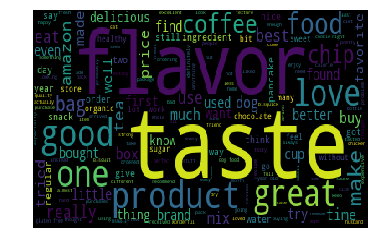

In [102]:
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 1
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(cluster1)):
    t_b = t_b + cluster1[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

<b>Observations:</b><br>
The cluster highlights words like taste,flavor, great, product etc. Overall the cluster seems to depict good reviews

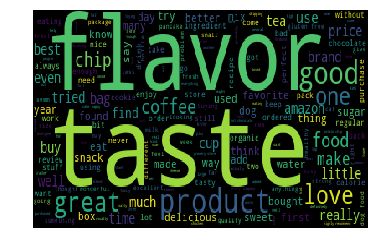

In [103]:
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 2
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(cluster2)):
    t_b = t_b + cluster2[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

<b>Observations:</b><br>
The words like flavor and taste are grouped and highlighted again in this cluster too.

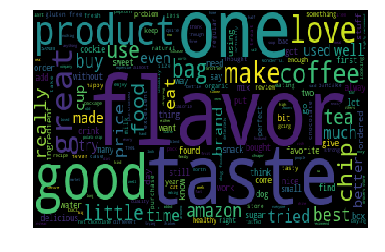

In [104]:
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 3
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(cluster3)):
    t_b = t_b + cluster3[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

<b>Observations:</b><br>
Words like 'coffee','tea' etc. can be seen in this cluster which would mean that there are some reviews about these sales also.

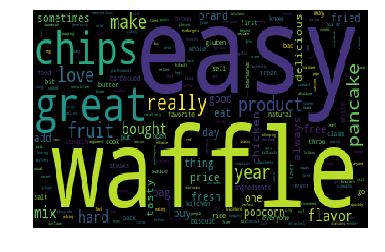

In [105]:
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 4
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(cluster4)):
    t_b = t_b + cluster4[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

<b>Observations:</b><br>
This cluster shows words like 'easy','waffle','chips' etc. from which we can assume that there are some varieties of foods being sold. 

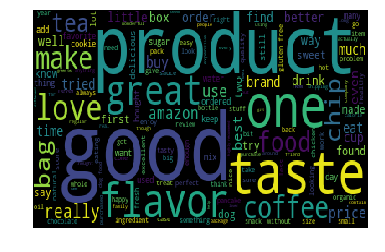

In [106]:
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 5
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(cluster5)):
    t_b = t_b + cluster5[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

<b>Observation:</b><br>
1.The above cluster shows words like 'product','good','flavor' etc like in the other clusters. This shows these are the most reviewed after words. 

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [107]:
# Please write all the code with proper documentation
data = tfidf_sent_vectors

<h4>Agglomerative clustering with 2 clusters</h4>

In [108]:
#https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob/master/Apply%20Hierarchical%20clustering%20on%20Amazon%20Food%20Reviews.ipynb
model = AgglomerativeClustering(n_clusters=2).fit(data)

reviews = X
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  2791

No. of reviews in Cluster-2 :  2195


<h4>Agglomerative clustering using 5 clusters</h4>

In [111]:
model = AgglomerativeClustering(n_clusters=5).fit(data)

# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif model.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif model.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif model.labels_[i] == 3:
        cluster4.append(reviews[i])
    else :
        cluster5.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))

No. of reviews in Cluster-1 :  1261

No. of reviews in Cluster-2 :  882

No. of reviews in Cluster-3 :  1530

No. of reviews in Cluster-4 :  1298

No. of reviews in Cluster-5 :  15


### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

<h4>wordcloud for agglomerative clustering using 2 clusters</h4>

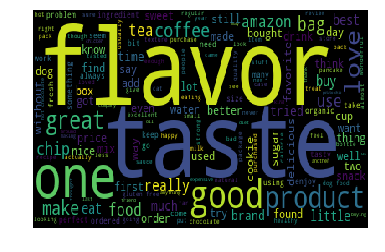

In [109]:
# Please write all the code with proper documentation
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 1
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(cluster1)):
    t_b = t_b + cluster1[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

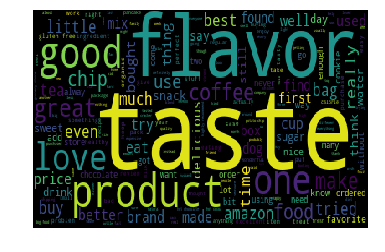

In [110]:
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 2
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(cluster2)):
    t_b = t_b + cluster2[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

<b>Observations:</b><br>
1.Words like 'flavor','taste' etc are repeated in the above 2 clusters and are in a bigger font.

<h4>wordcloud for agglomerative clustering using 5 clusters</h4>

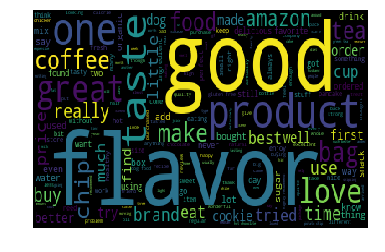

In [112]:
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 1
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(cluster1)):
    t_b = t_b + cluster1[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

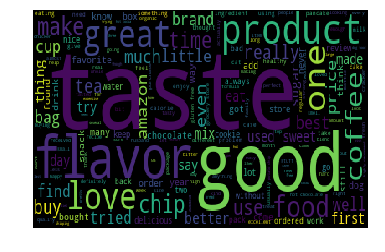

In [113]:
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 2
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(cluster2)):
    t_b = t_b + cluster2[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

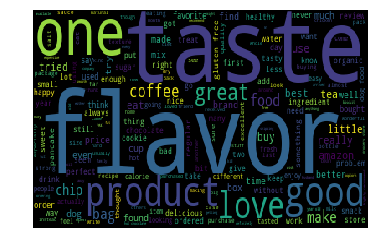

In [114]:
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 3
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(cluster3)):
    t_b = t_b + cluster3[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

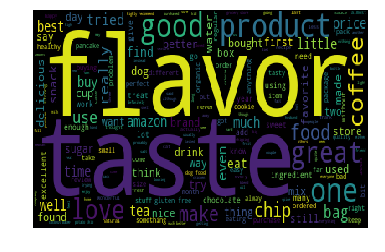

In [115]:
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 4
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(cluster4)):
    t_b = t_b + cluster4[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

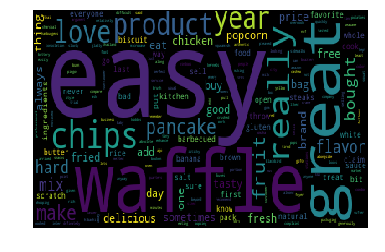

In [116]:
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 5
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(cluster5)):
    t_b = t_b + cluster5[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

<b>Observation</b><br>
1.From the wordcloud we can see that words like 'amazon','product','food' are seen as the biggest among all others.<br>
2.From these words we can assume that most of them are good reviews.

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [117]:
#https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob/master/Apply%20DBSCAN%20on%20Amazon%20Fine%20Food%20Reviews.ipynb
# Please write all the code with proper documentation
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# We will collect different 10K rows without repetition from time_sorted_data dataframe
my_final = time_sorted_data.take(np.random.permutation(len(final))[:5000])

x = final['Cleaned_text'].values

In [118]:
#https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob/master/Apply%20DBSCAN%20on%20Amazon%20Fine%20Food%20Reviews.ipynb
# function to determine the distance of nth-nearest neighbour to all points in a multi-dimensional array
def n_neighbour(vectors , n):
    distance = []
    for point in vectors:
        temp = np.sort(np.sum((vectors-point)**2,axis=1),axis=None)
        distance.append(temp[n])
    return np.sqrt(np.array(distance))

In [119]:
#https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob/master/Apply%20DBSCAN%20on%20Amazon%20Fine%20Food%20Reviews.ipynb
# Function definition for implementing DBSCAN
def dbscan(epsilon, samples, Data):
    from sklearn.cluster import DBSCAN
    db = DBSCAN(eps=epsilon, min_samples=samples, n_jobs=-1).fit(Data)
    
    # Number of clusters in labels, ignoring noise(-1) if present.
    n_clusters = len(set(db.labels_))
    print("Number of clusters for MinPts = %d and Epsilon = %f is : %d "%(samples,epsilon,n_clusters))
    print("Labels(-1 is for Noise) : ",set(db.labels_))
    print()
    return db

In [120]:
#Standardising the data
data = StandardScaler().fit_transform(sent_vectors)

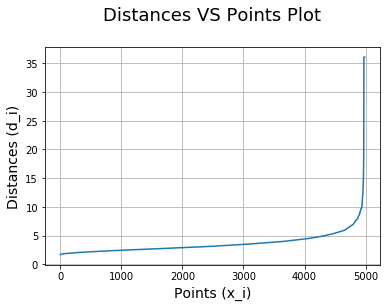

In [121]:
#https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob/master/Apply%20DBSCAN%20on%20Amazon%20Fine%20Food%20Reviews.ipynb
min_points = 2*data.shape[1]

# Computing distances of nth-nearest neighbours
distances = n_neighbour(data,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(data.shape[0])]

# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_distance)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()

<b>Observation:</b><br>
1.From the graph we can see that the eps=7 value is the point where the graph takes a sharp turn.Thus we will take it as the optimal_k

In [122]:
#https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob/master/Apply%20DBSCAN%20on%20Amazon%20Fine%20Food%20Reviews.ipynb
optimal_eps = 7
# Clustering with right epsilon
db1 = dbscan(optimal_eps, min_points, data)


# Clustering with  epsilon = 8
db2 = dbscan(8, min_points, data)


# Clustering with epsilon = 9
db3 = dbscan(9, min_points, data)


# Clustering with epsilon = 10
db4 = dbscan(10, min_points, data)


Number of clusters for MinPts = 100 and Epsilon = 7.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 100 and Epsilon = 8.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 100 and Epsilon = 9.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 100 and Epsilon = 10.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}



In [131]:
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []


for i in range(db1.labels_.shape[0]):
    if db1.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif db1.labels_[i] == -1:
        cluster2.append(reviews[i])
    
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2(these are noise basically) : ",len(cluster2))


No. of reviews in Cluster-1 :  4952

No. of reviews in Cluster-2(these are noise basically) :  34


### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

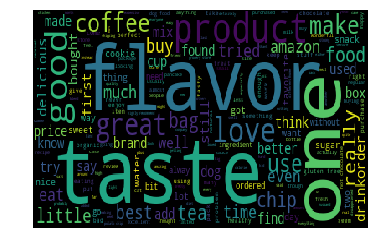

In [132]:
# Please write all the code with proper documentation
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 1
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(cluster1)):
    t_b = t_b + cluster1[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

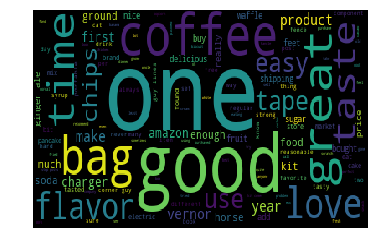

In [133]:
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 2
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(cluster2)):
    t_b = t_b + cluster2[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

<b>Observations:</b><br>
1.Cluster 1 shows words like 'flavor','one','taste' etc.<br>
2.Cluster 2 shows words like 'one', 'good','great' etc. from which we can assume that the reviews were given positively.

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [134]:
#https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob/master/Apply%20DBSCAN%20on%20Amazon%20Fine%20Food%20Reviews.ipynb# Please write all the code with proper documentation
#Standardising the data
data = StandardScaler().fit_transform(tfidf_sent_vectors)

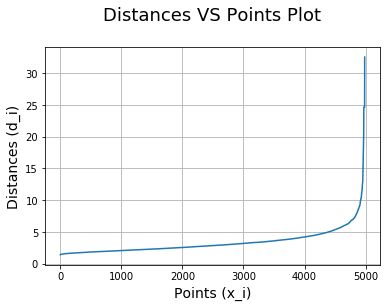

In [135]:
#https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob/master/Apply%20DBSCAN%20on%20Amazon%20Fine%20Food%20Reviews.ipynb
min_points = 2*data.shape[1]

# Computing distances of nth-nearest neighbours
distances = n_neighbour(data,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(data.shape[0])]

# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_distance)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()

<b>Observations:</b><br>
1.The curve takes a sharp curve at eps=7 here too, thus we can take this as the optimal_k

In [136]:
#https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob/master/Apply%20DBSCAN%20on%20Amazon%20Fine%20Food%20Reviews.ipynb
optimal_eps = 7
# Clustering with right epsilon
db1 = dbscan(optimal_eps, min_points, data)


# Clustering with  epsilon = 8
db2 = dbscan(8, min_points, data)


# Clustering with epsilon = 9
db3 = dbscan(9, min_points, data)


# Clustering with epsilon = 10
db4 = dbscan(10, min_points, data)

Number of clusters for MinPts = 100 and Epsilon = 7.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 100 and Epsilon = 8.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 100 and Epsilon = 9.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 100 and Epsilon = 10.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}



In [137]:
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []


for i in range(db1.labels_.shape[0]):
    if db1.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif db1.labels_[i] == -1:
        cluster2.append(reviews[i])
    
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2(these are noise basically) : ",len(cluster2))

No. of reviews in Cluster-1 :  4944

No. of reviews in Cluster-2(these are noise basically) :  42


### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

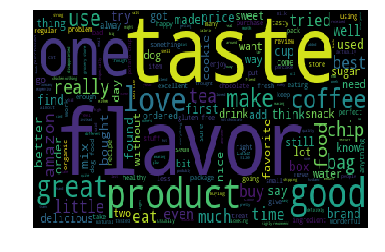

In [138]:
# Please write all the code with proper documentation
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 1
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(cluster1)):
    t_b = t_b + cluster1[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

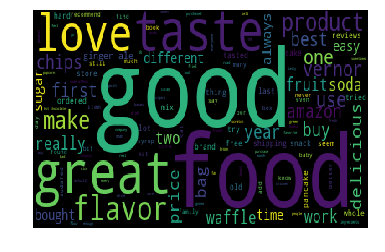

In [139]:
#https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/Kmeans.ipynb
#wordcloud for cluster 2
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(cluster2)):
    t_b = t_b + cluster2[j]+ ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

<b>Observation:</b><br>
1.In cluster 1 words like 'one','taste','flavor' etc. <br>
2.In cluster 2 words like 'good','food','great' etc.thus we can can assume from the above cluster that the food reviews and most of them were better.

# [6] Conclusions

In [151]:
# Please compare all your models using Prettytable library. 
# You can have 3 tables, one each for kmeans, agllomerative and dbscan
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["kmeans clustering", "optimal k"]

x.add_row(["BOW", 8])
x.add_row(["TFIDF",7 ])
x.add_row(["Avg W2V",4 ])
x.add_row(["tfidf Avg W2V",2 ])

print(x)

+-------------------+-----------+
| kmeans clustering | optimal k |
+-------------------+-----------+
|        BOW        |     8     |
|       TFIDF       |     7     |
|      Avg W2V      |     4     |
|   tfidf Avg W2V   |     2     |
+-------------------+-----------+


In [152]:
x = PrettyTable()

x.field_names = ["agglomerative clustering", "number of clusters","common words"]


x.add_row(["Avg W2V",2,"flavor,taste"])
x.add_row(["tfidf Avg W2V",2,"flavor,taste" ])
x.add_row(["Avg W2V",5,"flavor,taste,waffle,great" ])
x.add_row(["tfidf Avg W2V",5,"good,flavor,taste,easy" ])

print(x)

+--------------------------+--------------------+---------------------------+
| agglomerative clustering | number of clusters |        common words       |
+--------------------------+--------------------+---------------------------+
|         Avg W2V          |         2          |        flavor,taste       |
|      tfidf Avg W2V       |         2          |        flavor,taste       |
|         Avg W2V          |         5          | flavor,taste,waffle,great |
|      tfidf Avg W2V       |         5          |   good,flavor,taste,easy  |
+--------------------------+--------------------+---------------------------+


In [153]:
x = PrettyTable()

x.field_names = ["DBSCAN clustering", "eps value"]


x.add_row(["Avg W2V",7])
x.add_row(["tfidf Avg W2V",7])


print(x)

+-------------------+-----------+
| DBSCAN clustering | eps value |
+-------------------+-----------+
|      Avg W2V      |     7     |
|   tfidf Avg W2V   |     7     |
+-------------------+-----------+


<h3>Final Observation:</h3>

1.All the 3 clustering techniques seem to be doing a pretty good job in clustering the similar items.<br>
2.Words like 'flavor','good','taste' etc. has occurred in almost all types of clustering which would indicate that these are some of the words that occur in many review.<br>
3.The overall clustering can be thought of showcasing positive reviews by many people.